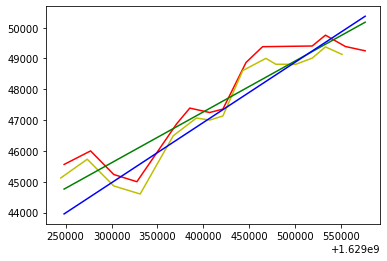

In [1]:
from mine import trend_utils
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from utils import date_utils

df1 = pd.read_csv('data/20200101-binance-1h.csv')

a = trend_utils.trend(df1[len(df1)-80:len(df1)].reset_index(drop=True))
a.graph(df1)


In [2]:
from binance.client import Client
import binance
from datetime import datetime 
import configparser
import json
import requests
import ccxt
import time
from pprint import pprint 
from mine import market


def table(values):
    first = values[0]
    keys = list(first.keys()) if isinstance(first, dict) else range(0, len(first))
    widths = [max([len(str(v[k])) for v in values]) for k in keys]
    string = ' | '.join(['{:<' + str(w) + '}' for w in widths])
    return "\n".join([string.format(*[str(v[k]) for k in keys]) for v in values])


def date_from_timestamp(timestamp):
    return(timestamp/1000)


config = configparser.ConfigParser()
config.read('/root/trading/config.ini')

API_KEY = config['BINANCE']['API_KEY']
SECRET_KEY = config['BINANCE']['SECRET_KEY']
API_URL = config['BINANCE']['API_URL']


print('CCXT Version: ', ccxt.__version__)
exchange_id = 'binance'
exchange = ccxt.binance({
    'options': {
        'adjustForTimeDifference': True,
        'defaultType': 'future'
    },
    'enableRateLimit': True,
    'apiKey': API_KEY,
    'secret': SECRET_KEY,
})

binance=ccxt.binance({
    'options': {
        'adjustForTimeDifference': True,
        # 'defaultType': 'future'
    },
    'rateLimit': 10000,
    'enableRateLimit': True,
    # 'verbose': True,
    'apiKey': API_KEY,
    'secret': SECRET_KEY,
})


CCXT Version:  1.45.42


In [ ]:
from mine import market, trend_utils
import asyncio
import nest_asyncio
import time
from datetime import datetime, timezone
import pandas as pd
from utils import ccxt_utils, cq_utils   
import pickle

nest_asyncio.apply()

BINANCE_SYMBOL = 'BTC/USDT'


async def hour():
    global trend
    global data
    print('hour')
    since = data['datetime'][len(data)-1]
    since_timestamp = binance.parse8601(since)
    
    data_1h = ccxt_utils.fetch_ohlcv(BINANCE_SYMBOL, binance, timeframe='1h', start=since, end=None)
    data_1h_df = ccxt_utils.ohlcv_to_df(data_1h['data'])
    data_1h_df.to_csv('data/temp.csv')
    
    data_1h_df=pd.read_csv('data/temp.csv').reset_index(drop=True)
    data=data.reset_index(drop=True)
    total=pd.concat([data, data_1h_df[1:]], ignore_index=True)

    d=total[len(data)-80:len(data)].reset_index(drop=True)
    trend=trend_utils.trend(d)
    data=total
    total=total.set_index('datetime',append=False)
    total.to_csv('data/20200101-binance-1h.csv')
    await asyncio.sleep(3600)
    
    
async def minute():
    print('minute')
    global data
    global trend
    global temp_position
    
    log=[]
    d=data[len(data)-80:len(data)]
    temp_price= binance.fetch_ticker('BTC/USDT')['close']
    position=trend.near_trend(temp_price)
    if position == 'buy' and not temp_position=='buy':
        
        if market.get_USDTbalance()>=10:
            order = binance.create_market_buy_order('BTC/USDT', market.get_USDTbalance())
        
        log.append([time.ctime(), 'buy', '-'])
        temp_position='buy'
        record=pd.DataFrame(log)
        record.to_csv("./data/trading.csv", mode='a')
    elif position == 'sell' and not temp_position=='sell':
        
        if market.get_USDTbalance()<10:
            order = binance.create_market_sell_order('BTC/USDT', market.get_BTCbalance())
        
        log.append([time.ctime(), 'sell', market.get_USDTbalance()])
        temp_position='sell'
        record=pd.DataFrame(log)
        record.to_csv("./data/trading.csv", mode='a')
    
    await asyncio.sleep(60)

async def min_loop():
    while True:
        await minute()
async def hour_loop():
    while True:
        await hour()

async def main():
    global data
    global trend
    global temp_position
    await asyncio.gather(min_loop(), hour_loop())

data=pd.read_csv('data/20200101-binance-1h.csv').reset_index(drop=True)
trend=trend_utils.trend(data[len(data)-80:len(data)].reset_index(drop=True))
temp_position='start'

loop=asyncio.get_event_loop()
try:
    loop.run_until_complete(main())  
except KeyboardInterrupt:
    print('end')
loop.close()


In [4]:
#test
from mine import market
import asyncio
import nest_asyncio
nest_asyncio.apply()

columns=['datetime', 'buy/sell', 'profit']
temp='start'
temp_price=df1['open'][0]
total_profit=100
data=[]
for i in range(81, len(df1)):
    d=df1[i-80:i].reset_index(drop=True)
    a=trend_utils.trend(d)
    position=a.near_trend(df1['close'][i-1])
    
    if position == 'buy' and not temp=='buy':
        #order = binance.create_market_buy_order('BTC/USDT', market.get_USDTbalance())
        buy_price=df1['close'][i-1]
        data.append([df1['datetime'][i-1], 'buy', '-'])
        temp='buy'
    elif position == 'sell' and not temp=='sell':
        #order = binance.create_market_sell_order('BTC/USDT', market.get_BTCbalance())
        #total_profit=total_profit*(10*d['high'][i-1]/temp_price-9)
        total_profit=total_profit*df1['high'][i-1]/buy_price
        data.append([df1['datetime'][i-1], 'sell', total_profit])
        temp='sell'

record=pd.DataFrame(data, columns=columns)
record.to_csv("./data/trading.csv", mode='a')
    

In [ ]:
#최적화
'''
from mine import market

columns=['size', 'profit']
temp='start'
temp_price=df1['open'][0]
total_profit=100
data=[]
size=1
while size < 50:
    total_profit=100
    temp_price=df1['open'][0]
    for i in range(81, len(df1)):
        d=df1.iloc[i-80:i].reset_index(drop=True)
        a=trend_utils.trend(d)
        position=a.near_trend(d, size/100)
    
        if position == 'buy' and not temp=='buy':
            #order = binance.create_market_buy_order('BTC/USDT', market.get_USDTbalance())
            temp_price=df1['close'][i-1]
            temp='buy'
        elif position == 'sell' and not temp=='sell':
            #order = binance.create_market_sell_order('BTC/USDT', market.get_BTCbalance())
            #total_profit=total_profit*(10*df1['high'][i-1]/temp_price-9)
            total_profit=total_profit*df1['close'][i-1]/temp_price
            temp='sell'
    data=[size, total_profit]
    print(data)
    record=pd.DataFrame([data], columns=columns)
    record.to_csv("./data/trading.csv", mode='a')
    size+=1
    
    '''